### **Regis Corp – Adult Income Machine Learning project**

*Welcome to Machine Learning Regis Corp.! Our task is to predict income house values in adult census data, given a number of features from the data.*
### Workspace setup
First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed, as well as Scikit-Learn ≥0.20. Please note that Python 2.x may work but, it is deprecated so we strongly recommend you use Python 3 instead. 

We will use XGBClassifier to build the classifier. We will see how to build a practical machine learning project. In general, any machine learning project requires the following steps:

Exploratory Data Analysis
Training the model
Fine tuning the model
Save the model
So let’s get started.

### Defining the problem statement
The data contains anonymous information such as age, occupation, education, working class, etc. The goal is to train a binary classifier to predict the income which has two possible values ‘>50K’ and ‘<50K’. There are 48842 instances and 14 attributes in the dataset. The data contains a good blend of categorical, numerical and missing values.

In [72]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import seaborn as sns

import json
import numpy as np
import os
import pandas as pd
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "adult_income_project"
FIGURES_PATH = os.path.join(PROJECT_ROOT_DIR, "figures", PROJECT_ID)
os.makedirs(FIGURES_PATH, exist_ok=True)

def save_figure(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(FIGURES_PATH, fig_id + "." + fig_extension)
    print("Saving plot", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# To ignore harmless warnings: https://github.com/scipy/scipy/issues/5998
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Get the data

In [2]:
adult_data_paths = ["http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"]

### Downloading the data
Instead of manually downloading the dataset, we will write a small script which downloads the content for a list of URLs and saves them in a folder. Later, we can directly use the downloaded data instead of hitting the network every time. You can also use this code for any machine learning project.

In [3]:
import requests
def load_dataset(path, adult_data_paths):
    if not os.path.exists(path):
        os.mkdir(path)

    for data_path in adult_data_paths:
        census_data = requests.get(data_path).content
        filename = os.path.join(path, os.path.basename(data_path))
        with open(filename, "wb") as file:
            file.write(census_data)

In [4]:
load_dataset('datasets/census_data/', adult_data_paths)

In [6]:
# load training set
with open('datasets/census_data/adult.data', 'r') as train_data:
    raw_training_data = pd.read_csv(train_data, header=None)


# load test set
with open('datasets/census_data/adult.test', 'r') as test_data:
    raw_testing_data = pd.read_csv(test_data, skiprows=1)

### Exploratory Data Analysis

### Let's check our train and test sets for any possible issues.

In [12]:
raw_training_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [13]:
raw_testing_data.head()

,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0.1,40,United-States,<=50K.
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


I notice a few problems immediately:

We don't have a column header for our data
There seem to be some unknown values in the fifth row of the test set (the question marks) we need to deal with
The target values have periods at the end in the test set but do not in the training set (<=50K. vs. <=50K)
Based on the accompanying dataset description, we can see the column names. Let's put those in for our train and test first.

There are some whitespaces before and after the data values. To trim all the whitespaces we use the separator ‘ *, *’. The test dataset has a weird first line, hence we skip the line using skiprows=1. The missing values in the dataset are indicated by ?
Next, we will explore the data. This is an important step before going building the model.

In [14]:
# these are the column labels from the census data files
COLUMNS = (
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income-level'
)

# categorical columns contain data that need to be turned into numerical
# values before being used by XGBoost
CATEGORICAL_COLUMNS = (
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country'
)

In [15]:
# load training set
with open('datasets/census_data/adult.data', 'r') as train_data:
    raw_training_data = pd.read_csv(train_data, header=None, names=COLUMNS)
# remove column we are trying to predict ('income-level') from features list
train_features = raw_training_data.drop('income-level', axis=1)
# create training labels list
train_labels = (raw_training_data['income-level'] == ' >50K')


# load test set
with open('datasets/census_data/adult.test', 'r') as test_data:
    raw_testing_data = pd.read_csv(test_data, names=COLUMNS, skiprows=1)
# remove column we are trying to predict ('income-level') from features list
test_features = raw_testing_data.drop('income-level', axis=1)
# create training labels list
test_labels = (raw_testing_data['income-level'] == ' >50K.')

### Applying Ordinal Encoding to Categoricals

In [16]:
# convert data in categorical columns to numerical values
encoders = {col:LabelEncoder() for col in CATEGORICAL_COLUMNS}
for col in CATEGORICAL_COLUMNS:
    train_features[col] = encoders[col].fit_transform(train_features[col])
for col in CATEGORICAL_COLUMNS:
    test_features[col] = encoders[col].fit_transform(test_features[col])

In [17]:
train_features.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5


In [21]:
test_features.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,38
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,38
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,38
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,38
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,38


In [24]:
# load data into DMatrix object
dtrain = xgb.DMatrix(train_features, train_labels)
dtest = xgb.DMatrix(test_features)

print('data loading complete')

data loading complete


In [25]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
age               32561 non-null int64
workclass         32561 non-null int64
fnlwgt            32561 non-null int64
education         32561 non-null int64
education-num     32561 non-null int64
marital-status    32561 non-null int64
occupation        32561 non-null int64
relationship      32561 non-null int64
race              32561 non-null int64
sex               32561 non-null int64
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null int64
dtypes: int64(14)
memory usage: 3.5 MB


In [26]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 14 columns):
age               16281 non-null int64
workclass         16281 non-null int64
fnlwgt            16281 non-null int64
education         16281 non-null int64
education-num     16281 non-null int64
marital-status    16281 non-null int64
occupation        16281 non-null int64
relationship      16281 non-null int64
race              16281 non-null int64
sex               16281 non-null int64
capital-gain      16281 non-null int64
capital-loss      16281 non-null int64
hours-per-week    16281 non-null int64
native-country    16281 non-null int64
dtypes: int64(14)
memory usage: 1.7 MB


### Data visualization

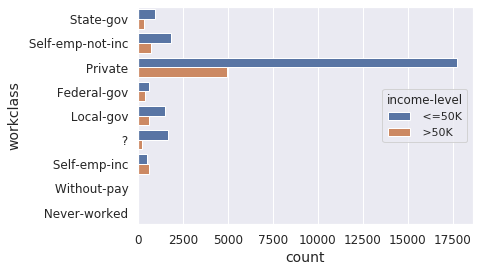

In [76]:
import seaborn as sns
sns.countplot(y='workclass', hue='income-level', data=raw_training_data)
plt.show()

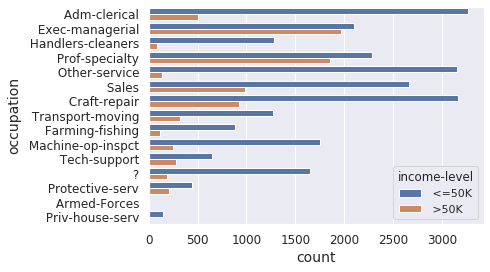

In [78]:
sns.countplot(y='occupation', hue='income-level', data=raw_training_data)
plt.show()

### Initial Model Setup and Grid Search
Now let's specify our parameters (with slightly different syntax in some places for the XGBoost native API) and set our stopping criteria. For now, let's be aggressive with the stopping and say we don't want the accuracy to improve for at least 100 new trees.

In [28]:
xgb_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

cv_xgb = xgb.cv(params = xgb_params, dtrain = dtrain, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], 
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

We can look at our CV results to see how accurate we were with these settings. The output is automatically saved into a pandas dataframe for us.

In [29]:
cv_xgb.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
595,0.111614,0.001367,0.126562,0.005041
596,0.111706,0.001424,0.126562,0.005063
597,0.111637,0.001399,0.126501,0.005134
598,0.111667,0.001494,0.126501,0.005248
599,0.111629,0.001481,0.126470,0.005365


Our CV test error at this number of iterations is 11.162%, or ~88% accuracy.

Now that we have our best settings, let's create this as an XGBoost object model that we can reference later.

In [34]:
xgb_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

bst = xgb.train(xgb_params, dtrain, num_boost_round = 599)

In [35]:
# train XGBoost model
bst = xgb.train(xgb_params, dtrain, num_boost_round = 599)
bst.save_model('./model.bst')

print('model trained and saved')

model trained and saved


In [49]:
%matplotlib inline
import seaborn as sns
sns.set(font_scale = 1.5)

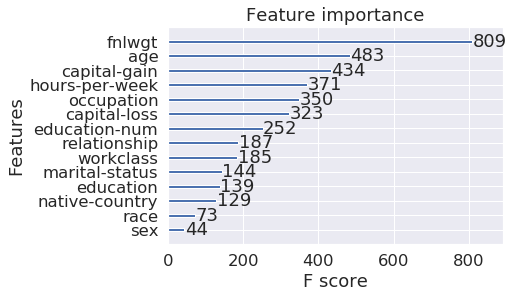

In [50]:
xgb.plot_importance(bst)
plt.show()

This will tell us which features were most important in the series of trees. The 'fnlwgt' feature seems to have the most importance. Filing capital gains was also important, which makes sense given that only those with greater incomes have the ability to invest. Race and sex were not as important. This may be because we are just predicting a specific threshold (below/above 50000 a year) instead of a precise income.

If the built-in feature importance method isn't what you wanted, you can make your own chart of feature importances using the get_fscore method:

In [51]:
importances = bst.get_fscore()
importances

{'relationship': 187,
 'education-num': 252,
 'capital-gain': 434,
 'age': 483,
 'fnlwgt': 809,
 'marital-status': 144,
 'hours-per-week': 371,
 'capital-loss': 323,
 'education': 139,
 'workclass': 185,
 'occupation': 350,
 'sex': 44,
 'race': 73,
 'native-country': 129}

Given this dictionary, we can now make a plot of it ourselves.

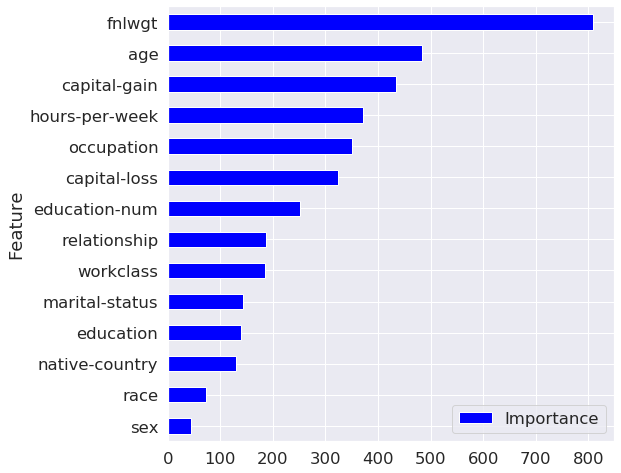

In [53]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'blue')
plt.show()

Now that we have an understanding of the feature importances, we can at least figure out better what is driving the splits most for the trees and where we may be able to make some improvements in feature engineering if possible. We can try playing around with the hyperparameters or engineer some new features to see if we can beat the current benchmarks.

### Analyzing Performance on Test Data
The model has now been tuned using cross-validation grid search through the sklearn API and early stopping through the built-in XGBoost API. Now, we can see how it finally performs on the test set. Does it match our CV performance? First, create another DMatrix (this time for the test data).

In [54]:
from sklearn.metrics import accuracy_score

dtest_pred = bst.predict(dtest) 
dtest_pred

array([0.00150327, 0.16199145, 0.29243305, ..., 0.7855829 , 0.1439268 ,
       0.7183667 ], dtype=float32)

We can see that the predict function for XGBoost outputs probabilities by default and not actual class labels. To calculate accuracy we need to convert these to a 0/1 label. We will set 0.5 probability as our threshold.

In [55]:
dtest_pred[dtest_pred > 0.5] = 1
dtest_pred[dtest_pred <= 0.5] = 0
dtest_pred

array([0., 0., 0., ..., 1., 0., 1.], dtype=float32)

Now we can calculate the accuracy

In [56]:
accuracy_score(dtest_pred, test_labels), 1-accuracy_score(dtest_pred, test_labels)

(0.8722437196732388, 0.12775628032676123)

Our final accuracy is 87.22%, or a 12.77% error rate. We beat our goal by a whole percentage point!

There is probably more that we could do to improve this model, such as additional hyperparameter tuning or even some additional feature engineering. However, according to the guidelines of the original data, we beat their best performance. It has been 20 years since the data was originally submitted . . . so we shouldn't be too surprised!

### Make an online prediction¶
It’s time to make an online prediction with your newly deployed model. Before you begin, you'll need to take some of the test data and prepare it, so that the test data can be used by the deployed model.

To get online predictions, the data needs to be converted from a numpy array to a json array.

In [61]:
import json
import numpy as np

data = []
for i in range(len(test_features)):
  data.append([])
  for col in COLUMNS[:-1]: # ignore 'income-level' column as it isn't in feature set.
    # convert from numpy integers to standard integers
    data[i].append(int(np.uint64(test_features[col][i]).item()))

# write the test data to a json file
with open('data.json', 'w') as outfile:
  json.dump(data, outfile)

# get one person that makes <=50K and one that makes >50K to test our model.
print('Show a person that makes <=50K:')
print('\tFeatures: {0} --> Label: {1}\n'.format(data[0], test_labels[0]))

with open('less_than_50K.json', 'w') as outfile:
  json.dump(data[0], outfile)

  
print('Show a person that makes >50K:')
print('\tFeatures: {0} --> Label: {1}'.format(data[2], test_labels[2]))

with open('more_than_50K.json', 'w') as outfile:
  json.dump(data[2], outfile)

Show a person that makes <=50K:
	Features: [25, 4, 226802, 1, 7, 4, 7, 3, 2, 1, 0, 0, 40, 38] --> Label: False

Show a person that makes >50K:
	Features: [28, 2, 336951, 7, 12, 2, 11, 0, 4, 1, 0, 0, 40, 38] --> Label: True


In [62]:
local = pd.Series(dtest_pred, name='local')

In [63]:
local[:10]

0    0.0
1    0.0
2    0.0
3    1.0
4    0.0
5    0.0
6    0.0
7    1.0
8    0.0
9    0.0
Name: local, dtype: float32

In [64]:
# Print the first 10 responses
for i, response in enumerate(local[:10]):
    print('Prediction: {}\tLabel: {}'.format(response, test_labels[i]))

Prediction: 0.0	Label: False
Prediction: 0.0	Label: False
Prediction: 0.0	Label: True
Prediction: 1.0	Label: True
Prediction: 0.0	Label: False
Prediction: 0.0	Label: False
Prediction: 0.0	Label: False
Prediction: 1.0	Label: True
Prediction: 0.0	Label: False
Prediction: 0.0	Label: False


In [65]:
from sklearn.metrics import classification_report
target_names = ['income-level <= 50', 'income-level> 50']
print(classification_report(dtest_pred, test_labels))

              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92     13535
         1.0       0.59      0.82      0.68      2746

    accuracy                           0.87     16281
   macro avg       0.77      0.85      0.80     16281
weighted avg       0.90      0.87      0.88     16281



[[11945   490]
 [ 1590  2256]]


Text(66.5, 0.5, 'Actual classes')

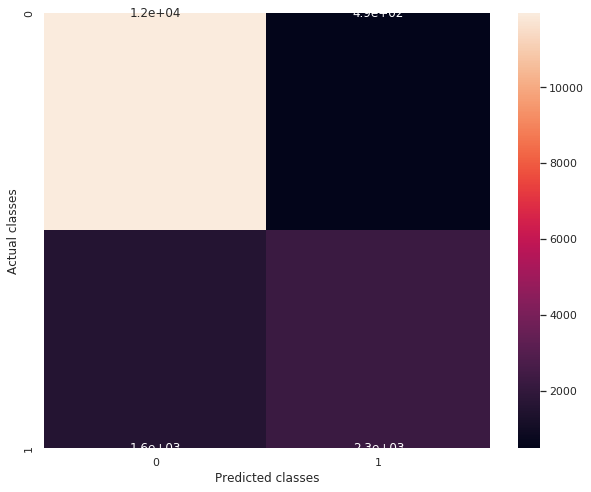

In [70]:
from sklearn.metrics import confusion_matrix
sns.set(rc={'figure.figsize':(10,8)})
cfm = confusion_matrix(test_labels, dtest_pred)
sns.heatmap(cfm, annot=True)
print(cfm)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')